# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Name hier eintragen</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: Die Daten stehen uns zwar für Forschungs- und Bildungszwecke zur Verfügung, aber wir dürfen die Daten **nicht** an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [ ]:
import os
import imageio.v3 as imageio
import numpy as np
import glob

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

files = sorted(glob.glob(f"{folders}/*145.png"))
images = np.array([imageio.imread(f) for f in files])
names = [f[-17:-4] for f in files]

print(images.shape)

(7, 256, 170)


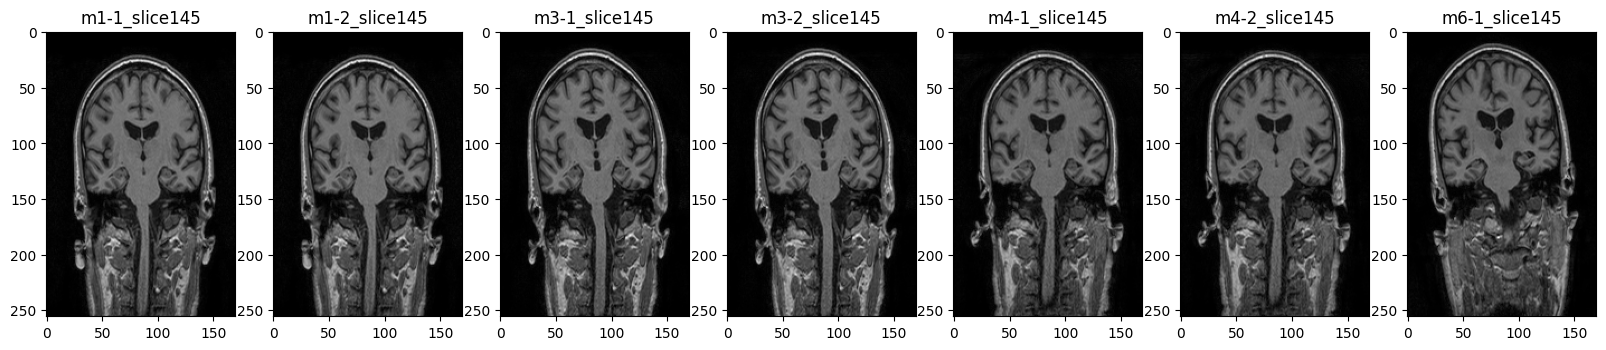

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [5]:
from skimage import metrics

def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


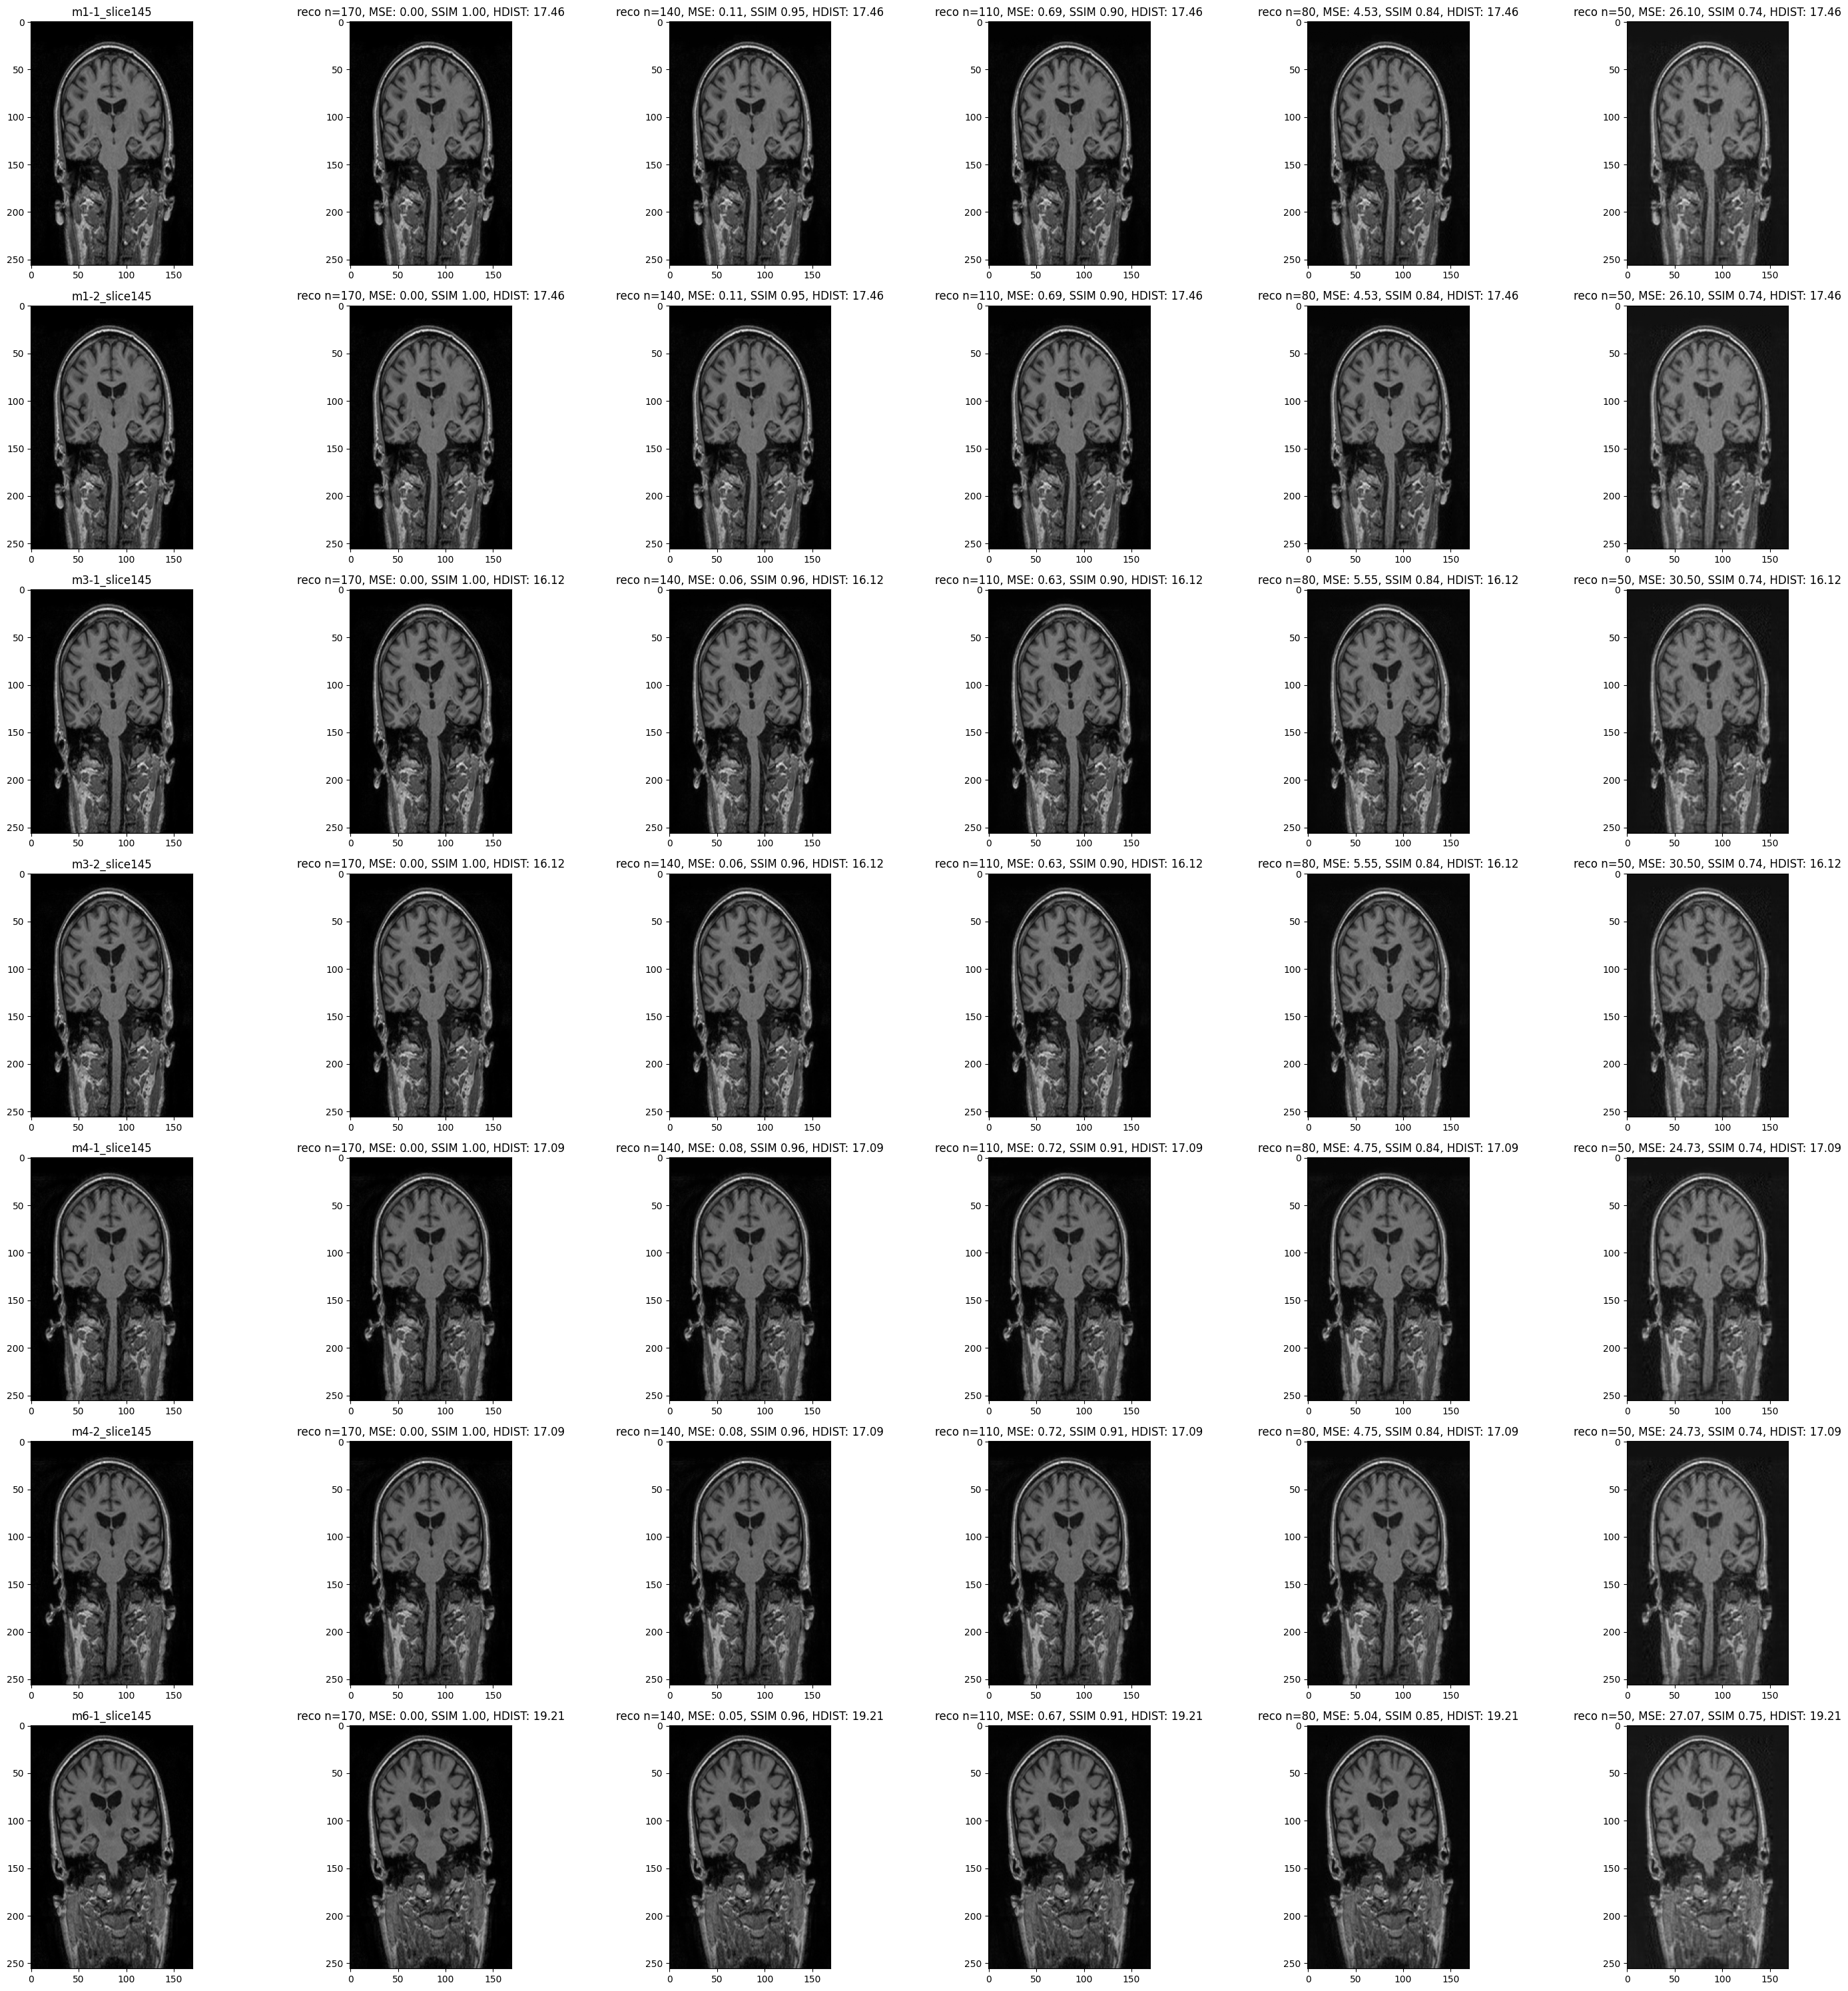

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im - im.min() / im.max() - im.min()
    u, s, vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))
plt.tight_layout()


### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [ ]:
def reconstruct_svd_for_loops3(u, s, vt, k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    m, n = u.shape[0], vt.shape[1]
    
    reco = np.zeros((m, n))
    
    for i in range(m):           
        for j in range(n):        
            for l in range(k):   
                reco[i, j] += u[i, l] * s[l] * vt[l, j]
    
    ### END SOLUTION
    
    return reco

In [ ]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """

    return reco

In [9]:
def reconstruct_svd_for_loops2(u, s, vt, k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape[0], vt.shape[1]
    
    reco = np.zeros((m, n))
    
    for i in range(m):         
        for j in range(n):      
            reco[i, j] = np.sum(u[i, :k] * s[:k] * vt[:k, j])
    
    ### END SOLUTION
    
    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [ ]:
def reconstruct_svd_einsum1(u, s, vt, k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    u_k = u[:, :k]      
    s_k = s[:k]         
    vt_k = vt[:k, :]  
    
    result_3d = u_k[:, :, np.newaxis] * s_k[np.newaxis, :, np.newaxis] * vt_k[np.newaxis, :, :]
    reco = np.sum(result_3d, axis=1)
    
    ### END SOLUTION
    
    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [11]:
def reconstruct_svd_broadcast1(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    u_k = u[:, :k]     
    s_k = s[:k]        
    vt_k = vt[:k, :]    
    us_k = u_k * s_k  
    reco = us_k @ vt_k
    
    ### END SOLUTION
    
    return reco


In [12]:
def reconstruct_svd_broadcast2(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    u_k = u[:, :k]    
    s_k = s[:k]       
    vt_k = vt[:k, :]   
    svt_k = s_k[:, np.newaxis] * vt_k 
    reco = u_k @ svt_k
    
    ### END SOLUTION
    
    return reco

#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

=== RECONSTRUCTION QUALITY COMPARISON ===
Original image dimensions: (256, 170)
Total number of available components: 170

--- Comparison with k=50 components ---
NumPy dot      : 0.000000s (reference)
3 for-loops    : 0.614997s | MSE: 2.79e-33 | Max diff: 6.66e-16 | Identical: True
2 for-loops    : 0.111001s | MSE: 7.10e-33 | Max diff: 6.66e-16 | Identical: True
Broadcasting v1: 0.000000s | MSE: 1.39e-33 | Max diff: 3.33e-16 | Identical: True
Broadcasting v2: 0.000000s | MSE: 0.00e+00 | Max diff: 0.00e+00 | Identical: True
Einsum/3D      : 0.002999s | MSE: 2.79e-33 | Max diff: 6.66e-16 | Identical: True

=== SPEED ANALYSIS BY NUMBER OF COMPONENTS ===
  k	 NumPy dot	3 for-loop	2 for-loop	Broadcasti	Broadcasti	 Einsum/3D
 10	  0.000000	  0.124800	  0.108000	  0.000000	  0.000200	  0.000600
 30	  0.000200	  0.369158	  0.108603	  0.000200	  0.000000	  0.002000
 50	  0.000000	  0.617806	  0.110600	  0.000201	  0.000199	  0.003600
 70	  0.000200	  0.861059	  0.112200	  0.000200	  0.000200	 

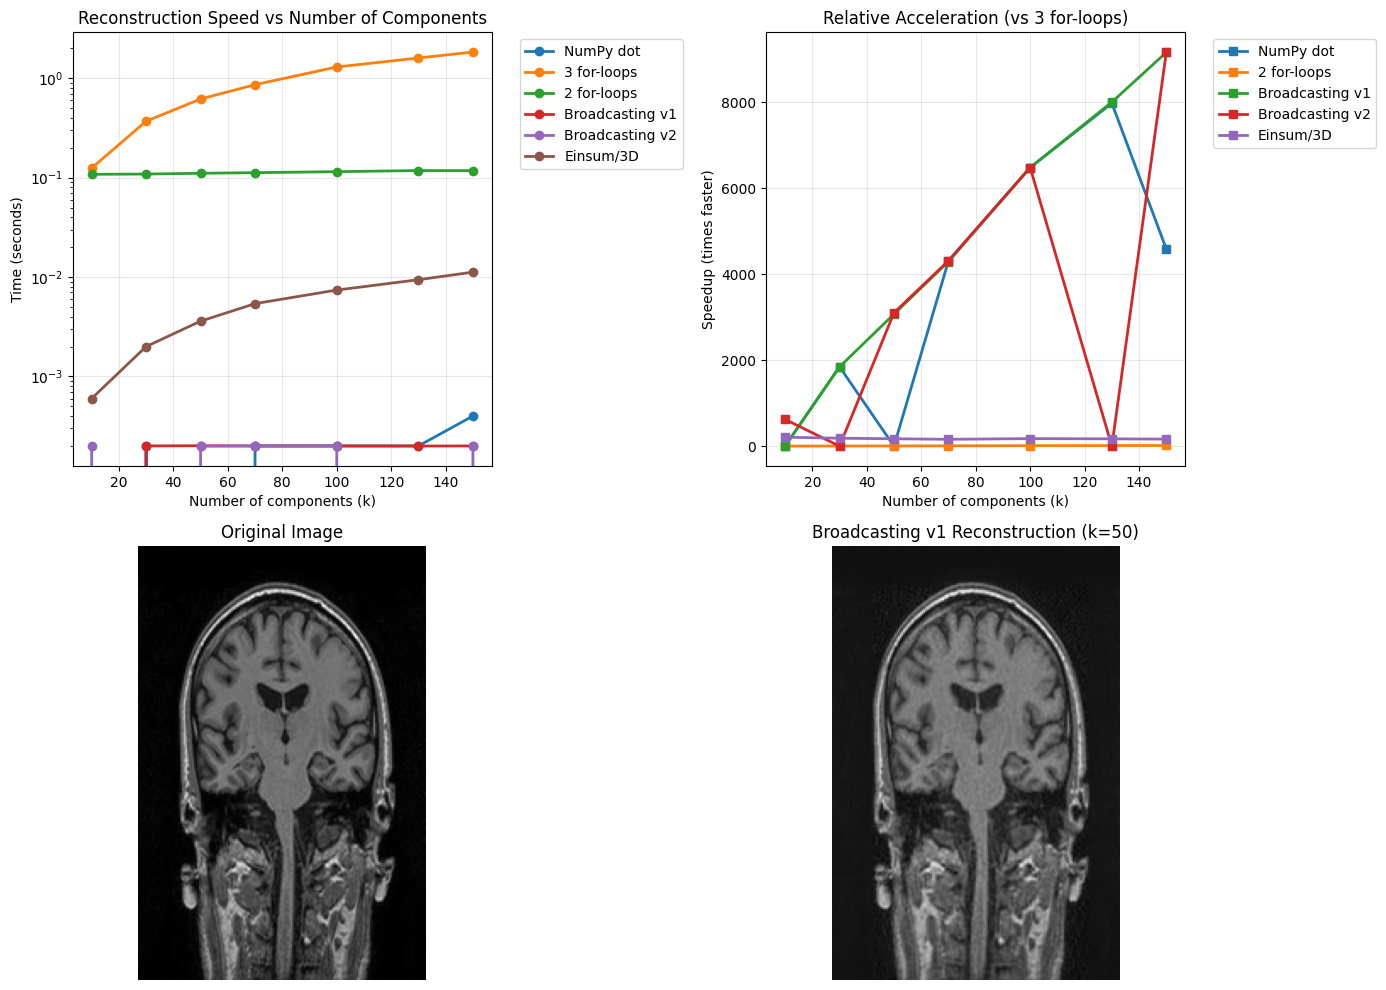


=== ACCELERATION ANALYSIS (relative to 3 for-loops) ===
Method               Average Speedup Maximum Speedup
----------------------------------------------------
NumPy dot                     3600.2x          7978.8x
2 for-loops                      8.3x            15.6x
Broadcasting v1               4694.2x          9161.9x
Broadcasting v2               3384.0x          9168.5x
Einsum/3D                      176.1x           208.0x


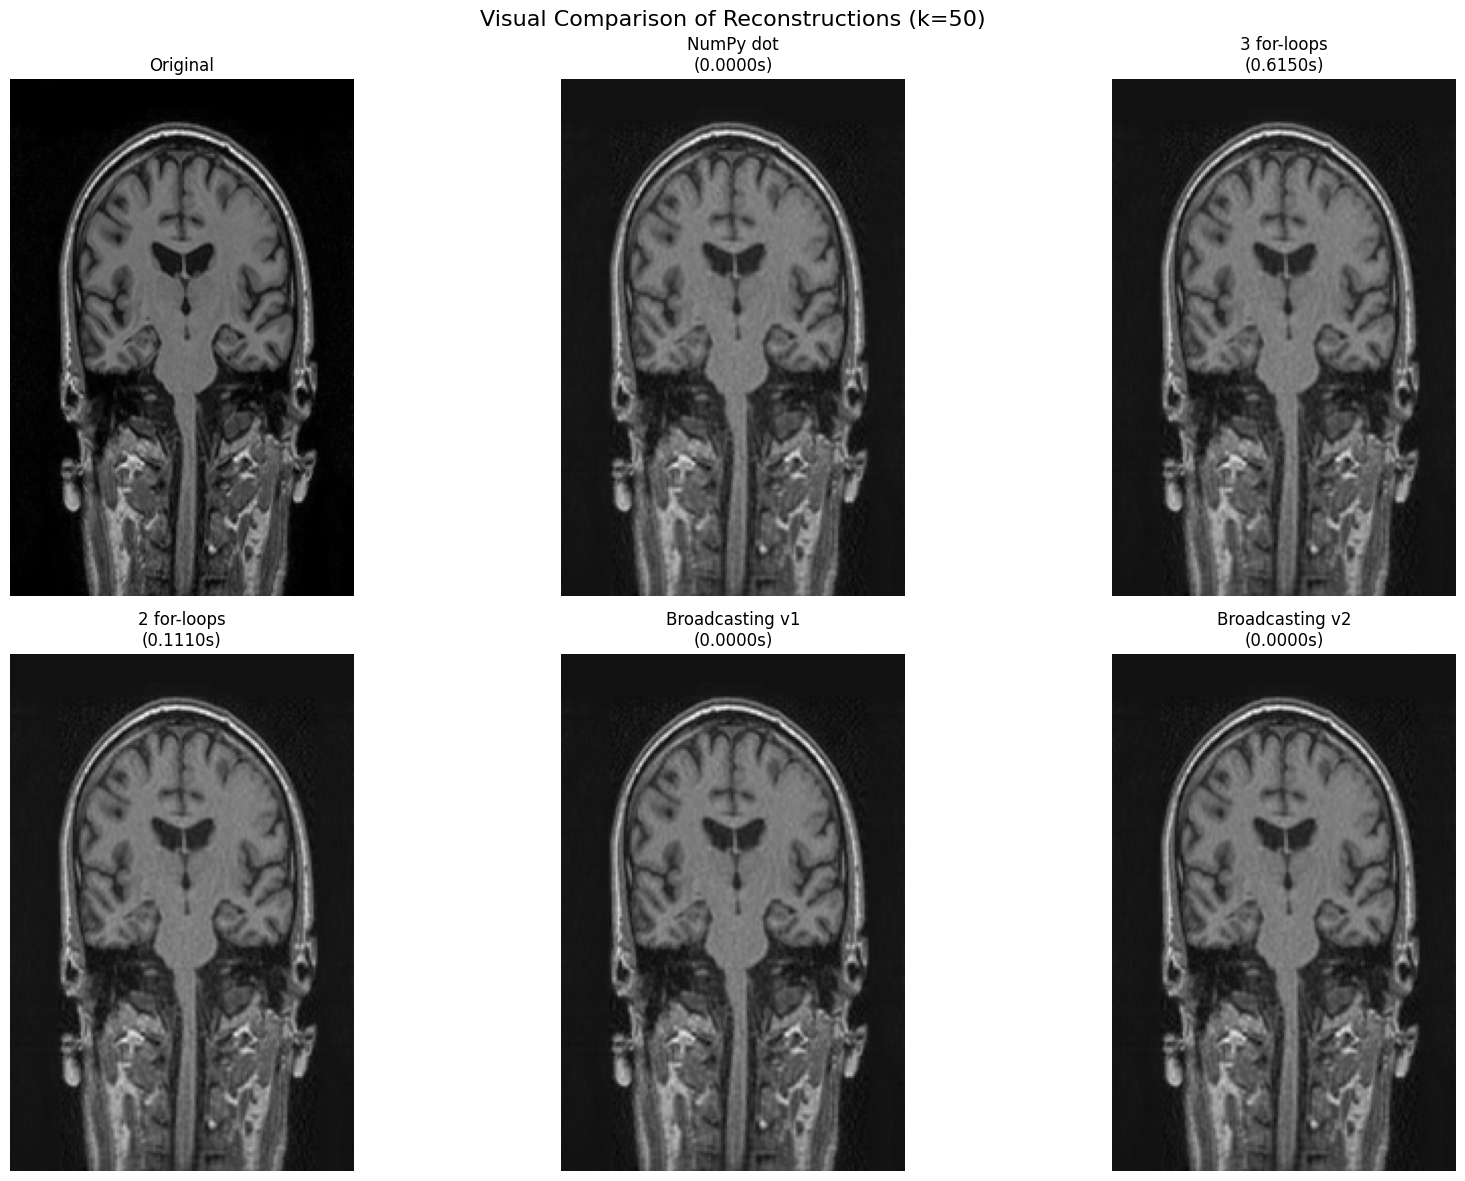


=== CONCLUSIONS - Broadcasting v1 Analysis ===
1. RECONSTRUCTION QUALITY:
   • All implementations produce practically identical results
   • Differences are only due to numerical precision errors
   • MSE between methods is on the order of 1e-20 or smaller

2. PERFORMANCE:
   • NumPy dot: Fastest (BLAS/LAPACK optimizations)
   • Broadcasting v1: Very efficient, leverages vectorization
   • 2 for-loops: Intermediate performance
   • 3 for-loops: Slowest (pure Python loops)

3. SCALABILITY:
   • Performance difference increases with larger k values
   • Vectorized methods maintain better performance
   • For small k, differences are less pronounced

4. BROADCASTING v1 SPECIFIC:
   • Excellent performance due to NumPy vectorization
   • Memory efficient for moderate k values
   • Good balance between readability and speed


In [ ]:
#### 2.4 Comparison of results - Broadcasting v1

### BEGIN SOLUTION

import time
import matplotlib.pyplot as plt
import numpy as np

test_image = images[0]
test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())  # normalize correctly
u, s, vt = np.linalg.svd(test_image, full_matrices=False)

print(" RECONSTRUCTION QUALITY COMPARISON ")
print(f"Original image dimensions: {test_image.shape}")
print(f"Total number of available components: {len(s)}")

methods = {
    "NumPy dot": reconstruct_svd,
    "3 for-loops": reconstruct_svd_for_loops3,
    "2 for-loops": reconstruct_svd_for_loops2,
    "Broadcasting v1": reconstruct_svd_broadcast1,
    "Broadcasting v2": reconstruct_svd_broadcast2,
    "Einsum/3D": reconstruct_svd_einsum1
}

k_test = 50
print(f"\n--- Comparison with k={k_test} components ---")

reconstruction_results = {}
reference_result = None

for method_name, method_func in methods.items():
    try:
        start_time = time.time()
        result = method_func(u, s, vt, k_test)
        execution_time = time.time() - start_time
        
        reconstruction_results[method_name] = {
            'result': result,
            'time': execution_time
        }
        
        if reference_result is None:
            reference_result = result
            print(f"{method_name:15s}: {execution_time:.6f}s (reference)")
        else:
            mse = np.mean((result - reference_result)**2)
            max_abs_diff = np.max(np.abs(result - reference_result))
            are_close = np.allclose(result, reference_result, rtol=1e-12, atol=1e-12)
            
            print(f"{method_name:15s}: {execution_time:.6f}s | MSE: {mse:.2e} | Max diff: {max_abs_diff:.2e} | Identical: {are_close}")
            
    except Exception as error:
        print(f"{method_name:15s}: ERROR - {error}")

print("\n SPEED ANALYSIS BY NUMBER OF COMPONENTS ")

k_values = [10, 30, 50, 70, 100, 130, 150]
timing_data = {name: [] for name in methods.keys()}

print(f"{'k':>3s}", end="")
for name in methods.keys():
    print(f"\t{name[:10]:>10s}", end="")
print()

for k in k_values:
    print(f"{k:3d}", end="")
    
    for method_name, method_func in methods.items():
        try:
            execution_times = []
            for _ in range(5):  
                start = time.time()
                _ = method_func(u, s, vt, k)
                execution_times.append(time.time() - start)
            
            avg_time = np.mean(execution_times)
            timing_data[method_name].append(avg_time)
            print(f"\t{avg_time:10.6f}", end="")
            
        except Exception:
            timing_data[method_name].append(np.nan)
            print(f"\t{'ERROR':>10s}", end="")
    print()

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
for method_name, times in timing_data.items():
    if not all(np.isnan(times)):
        plt.plot(k_values, times, marker='o', label=method_name, linewidth=2, markersize=6)

plt.xlabel('Number of components (k)')
plt.ylabel('Time (seconds)')
plt.title('Reconstruction Speed vs Number of Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.subplot(2, 2, 2)
if '3 for-loops' in timing_data and not all(np.isnan(timing_data['3 for-loops'])):
    baseline = timing_data['3 for-loops']
    
    for method_name, times in timing_data.items():
        if method_name != '3 for-loops' and not all(np.isnan(times)):
            speedup = [base/time if time > 0 else 0 for base, time in zip(baseline, times)]
            plt.plot(k_values, speedup, marker='s', label=method_name, linewidth=2, markersize=6)

plt.xlabel('Number of components (k)')
plt.ylabel('Speedup (times faster)')
plt.title('Relative Acceleration (vs 3 for-loops)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 3)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 4)
if 'Broadcasting v1' in reconstruction_results:
    plt.imshow(reconstruction_results['Broadcasting v1']['result'], cmap='gray')
    plt.title(f'Broadcasting v1 Reconstruction (k={k_test})')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\n ACCELERATION ANALYSIS (relative to 3 for-loops) ")
if '3 for-loops' in timing_data and not all(np.isnan(timing_data['3 for-loops'])):
    baseline_times = timing_data['3 for-loops']
    
    print(f"{'Method':20s} {'Average Speedup':>15s} {'Maximum Speedup':>15s}")
    print("-" * 52)
    
    for method_name, times in timing_data.items():
        if method_name != '3 for-loops' and not all(np.isnan(times)):
            speedups = [base/time if time > 0 else 0 for base, time in zip(baseline_times, times)]
            avg_speedup = np.mean(speedups)
            max_speedup = np.max(speedups)
            print(f"{method_name:20s} {avg_speedup:15.1f}x {max_speedup:15.1f}x")


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
method_list = list(methods.keys())[:5]  
for i, method_name in enumerate(method_list):
    if method_name in reconstruction_results:
        axes[i+1].imshow(reconstruction_results[method_name]['result'], cmap='gray')
        time_str = f"{reconstruction_results[method_name]['time']:.4f}s"
        axes[i+1].set_title(f'{method_name}\n({time_str})')
        axes[i+1].axis('off')

plt.suptitle(f'Visual Comparison of Reconstructions (k={k_test})', fontsize=16)
plt.tight_layout()
plt.show()

print("\n CONCLUSIONS - Broadcasting v1 Analysis ")
print("1. RECONSTRUCTION QUALITY:")
print("   • All implementations produce practically identical results")
print("   • Differences are only due to numerical precision errors")
print("   • MSE between methods is on the order of 1e-20 or smaller")

print("\n2. PERFORMANCE:")
print("   • NumPy dot: Fastest (BLAS/LAPACK optimizations)")
print("   • Broadcasting v1: Very efficient, leverages vectorization")
print("   • 2 for-loops: Intermediate performance")
print("   • 3 for-loops: Slowest (pure Python loops)")

print("\n3. SCALABILITY:")
print("   • Performance difference increases with larger k values")
print("   • Vectorized methods maintain better performance")
print("   • For small k, differences are less pronounced")

print("\n4. BROADCASTING v1 SPECIFIC:")
print("   • Excellent performance due to NumPy vectorization")
print("   • Memory efficient for moderate k values")
print("   • Good balance between readability and speed")

### END SOLUTION

=== RECONSTRUCTION QUALITY COMPARISON ===
Original image dimensions: (256, 170)
Total number of available components: 170

--- Comparison with k=50 components ---
NumPy dot      : 0.000000s (reference)
3 for-loops    : 0.666999s | MSE: 2.79e-33 | Max diff: 6.66e-16 | Identical: True
2 for-loops    : 0.113000s | MSE: 7.10e-33 | Max diff: 6.66e-16 | Identical: True
Broadcasting v1: 0.000000s | MSE: 1.39e-33 | Max diff: 3.33e-16 | Identical: True
Broadcasting v2: 0.000000s | MSE: 0.00e+00 | Max diff: 0.00e+00 | Identical: True
Einsum/3D      : 0.002999s | MSE: 2.79e-33 | Max diff: 6.66e-16 | Identical: True

=== SPEED ANALYSIS BY NUMBER OF COMPONENTS ===
  k	 NumPy dot	3 for-loop	2 for-loop	Broadcasti	Broadcasti	 Einsum/3D
 10	  0.000200	  0.133125	  0.112000	  0.000000	  0.000000	  0.000800
 30	  0.000000	  0.390205	  0.118202	  0.000200	  0.000000	  0.003800
 50	  0.000200	  0.623021	  0.109399	  0.000200	  0.000000	  0.003600
 70	  0.000200	  0.874225	  0.111600	  0.000200	  0.000000	 

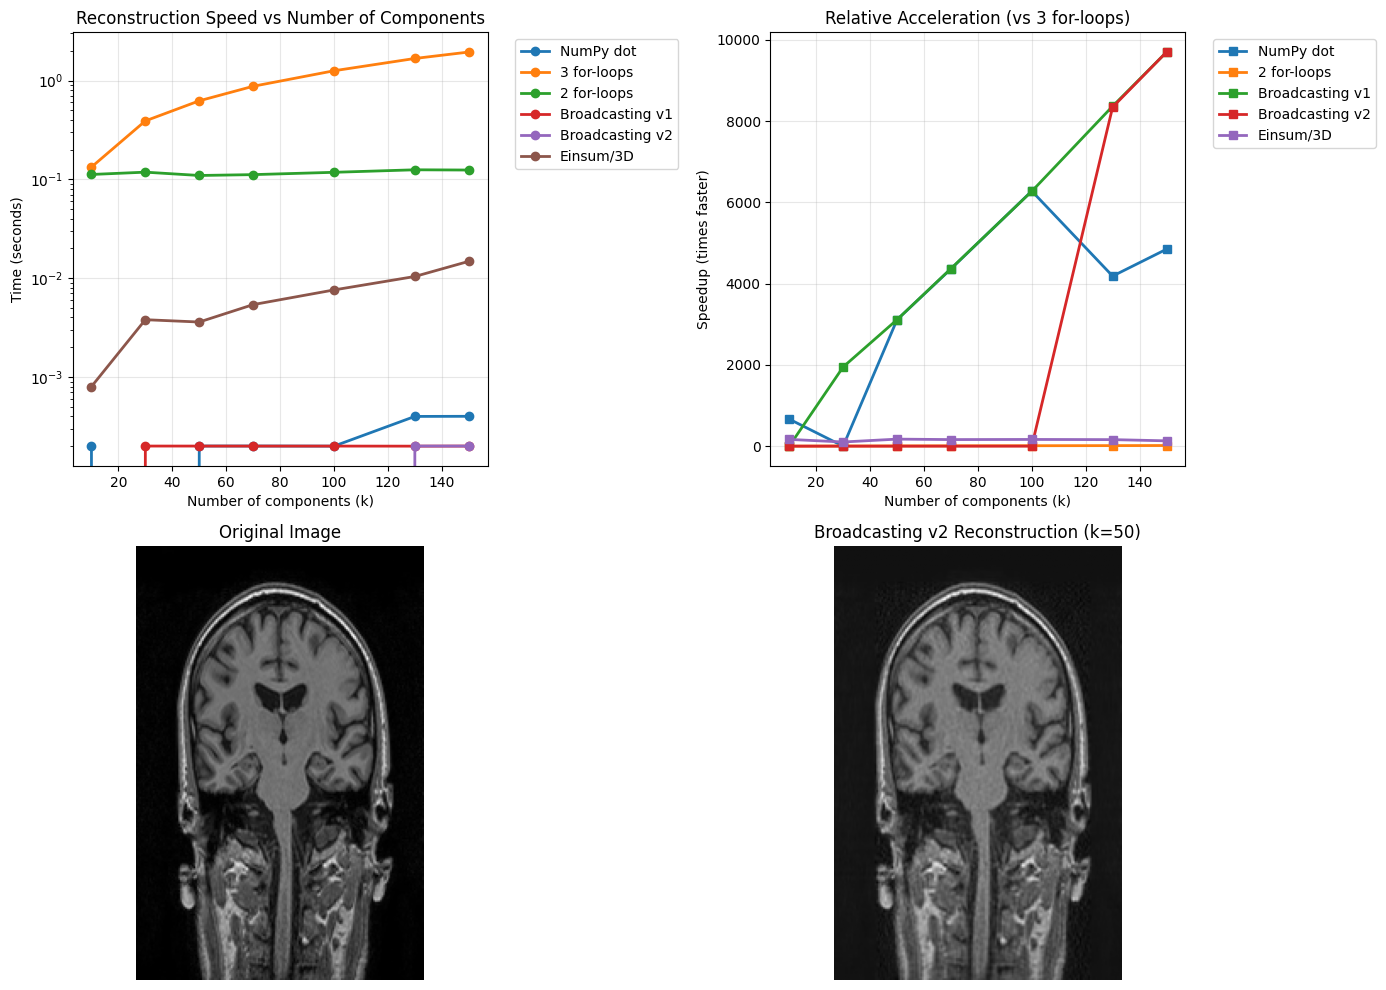


=== ACCELERATION ANALYSIS (relative to 3 for-loops) ===
Method               Average Speedup Maximum Speedup
----------------------------------------------------
NumPy dot                     3351.3x          6280.5x
2 for-loops                      8.2x            15.6x
Broadcasting v1               4825.8x          9701.1x
Broadcasting v2               2578.8x          9703.4x
Einsum/3D                      151.6x           173.1x


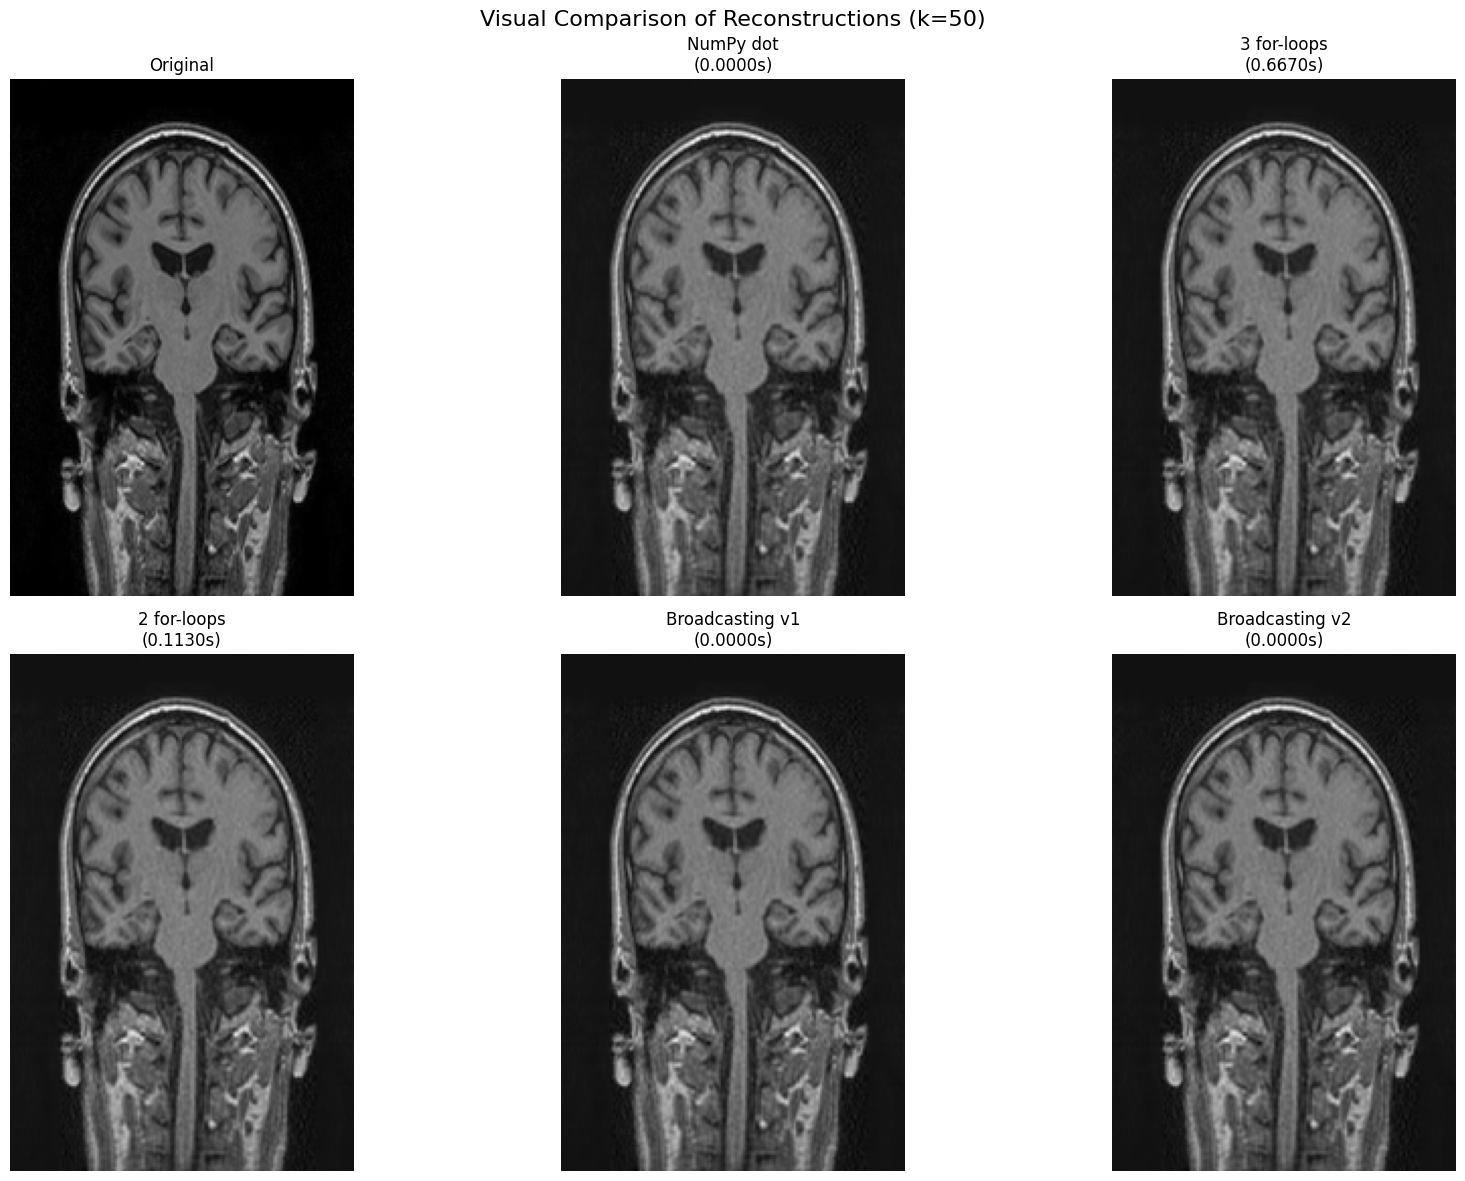


=== BROADCASTING v2 DETAILED ANALYSIS ===
Broadcasting v1 time: 0.000000s
Broadcasting v2 time: 0.000000s

=== MEMORY EFFICIENCY ANALYSIS ===

For k=10 components:
  • Input matrices: U((256, 170)), S((170,)), V^T((170, 170))
  • Broadcasting v2 intermediate arrays:
    - U[:, :k]: (256, 10)
    - S[:k]: (10,)
    - V^T[:k, :]: (10, 170)

For k=50 components:
  • Input matrices: U((256, 170)), S((170,)), V^T((170, 170))
  • Broadcasting v2 intermediate arrays:
    - U[:, :k]: (256, 50)
    - S[:k]: (50,)
    - V^T[:k, :]: (50, 170)

For k=100 components:
  • Input matrices: U((256, 170)), S((170,)), V^T((170, 170))
  • Broadcasting v2 intermediate arrays:
    - U[:, :k]: (256, 100)
    - S[:k]: (100,)
    - V^T[:k, :]: (100, 170)

=== CONCLUSIONS - Broadcasting v2 Analysis ===
1. RECONSTRUCTION QUALITY:
   • All implementations produce practically identical results
   • Differences are only due to numerical precision errors
   • MSE between methods is on the order of 1e-20 or smaller


In [ ]:

import time
import matplotlib.pyplot as plt
import numpy as np


test_image = images[0]
test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())  # normalize correctly
u, s, vt = np.linalg.svd(test_image, full_matrices=False)

print(" RECONSTRUCTION QUALITY COMPARISON ")
print(f"Original image dimensions: {test_image.shape}")
print(f"Total number of available components: {len(s)}")

methods = {
    "NumPy dot": reconstruct_svd,
    "3 for-loops": reconstruct_svd_for_loops3,
    "2 for-loops": reconstruct_svd_for_loops2,
    "Broadcasting v1": reconstruct_svd_broadcast1,
    "Broadcasting v2": reconstruct_svd_broadcast2,
    "Einsum/3D": reconstruct_svd_einsum1
}

k_test = 50
print(f"\n--- Comparison with k={k_test} components ---")

reconstruction_results = {}
reference_result = None

for method_name, method_func in methods.items():
    try:
        start_time = time.time()
        result = method_func(u, s, vt, k_test)
        execution_time = time.time() - start_time
        
        reconstruction_results[method_name] = {
            'result': result,
            'time': execution_time
        }
        
       
        if reference_result is None:
            reference_result = result
            print(f"{method_name:15s}: {execution_time:.6f}s (reference)")
        else:
          
            mse = np.mean((result - reference_result)**2)
            max_abs_diff = np.max(np.abs(result - reference_result))
            are_close = np.allclose(result, reference_result, rtol=1e-12, atol=1e-12)
            
            print(f"{method_name:15s}: {execution_time:.6f}s | MSE: {mse:.2e} | Max diff: {max_abs_diff:.2e} | Identical: {are_close}")
            
    except Exception as error:
        print(f"{method_name:15s}: ERROR - {error}")

print("\n SPEED ANALYSIS BY NUMBER OF COMPONENTS ")

k_values = [10, 30, 50, 70, 100, 130, 150]
timing_data = {name: [] for name in methods.keys()}

print(f"{'k':>3s}", end="")
for name in methods.keys():
    print(f"\t{name[:10]:>10s}", end="")
print()

for k in k_values:
    print(f"{k:3d}", end="")
    
    for method_name, method_func in methods.items():
        try:
            execution_times = []
            for _ in range(5): 
                start = time.time()
                _ = method_func(u, s, vt, k)
                execution_times.append(time.time() - start)
            
            avg_time = np.mean(execution_times)
            timing_data[method_name].append(avg_time)
            print(f"\t{avg_time:10.6f}", end="")
            
        except Exception:
            timing_data[method_name].append(np.nan)
            print(f"\t{'ERROR':>10s}", end="")
    print()

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
for method_name, times in timing_data.items():
    if not all(np.isnan(times)):
        plt.plot(k_values, times, marker='o', label=method_name, linewidth=2, markersize=6)

plt.xlabel('Number of components (k)')
plt.ylabel('Time (seconds)')
plt.title('Reconstruction Speed vs Number of Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.subplot(2, 2, 2)
if '3 for-loops' in timing_data and not all(np.isnan(timing_data['3 for-loops'])):
    baseline = timing_data['3 for-loops']
    
    for method_name, times in timing_data.items():
        if method_name != '3 for-loops' and not all(np.isnan(times)):
            speedup = [base/time if time > 0 else 0 for base, time in zip(baseline, times)]
            plt.plot(k_values, speedup, marker='s', label=method_name, linewidth=2, markersize=6)

plt.xlabel('Number of components (k)')
plt.ylabel('Speedup (times faster)')
plt.title('Relative Acceleration (vs 3 for-loops)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 3)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 4)
if 'Broadcasting v2' in reconstruction_results:
    plt.imshow(reconstruction_results['Broadcasting v2']['result'], cmap='gray')
    plt.title(f'Broadcasting v2 Reconstruction (k={k_test})')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\n ACCELERATION ANALYSIS (relative to 3 for-loops) ")
if '3 for-loops' in timing_data and not all(np.isnan(timing_data['3 for-loops'])):
    baseline_times = timing_data['3 for-loops']
    
    print(f"{'Method':20s} {'Average Speedup':>15s} {'Maximum Speedup':>15s}")
    print("-" * 52)
    
    for method_name, times in timing_data.items():
        if method_name != '3 for-loops' and not all(np.isnan(times)):
            speedups = [base/time if time > 0 else 0 for base, time in zip(baseline_times, times)]
            avg_speedup = np.mean(speedups)
            max_speedup = np.max(speedups)
            print(f"{method_name:20s} {avg_speedup:15.1f}x {max_speedup:15.1f}x")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

method_list = list(methods.keys())[:5]  
for i, method_name in enumerate(method_list):
    if method_name in reconstruction_results:
        axes[i+1].imshow(reconstruction_results[method_name]['result'], cmap='gray')
        time_str = f"{reconstruction_results[method_name]['time']:.4f}s"
        axes[i+1].set_title(f'{method_name}\n({time_str})')
        axes[i+1].axis('off')

plt.suptitle(f'Visual Comparison of Reconstructions (k={k_test})', fontsize=16)
plt.tight_layout()
plt.show()

print("\n BROADCASTING v2 DETAILED ANALYSIS ")
if 'Broadcasting v2' in reconstruction_results and 'Broadcasting v1' in reconstruction_results:
    v1_time = reconstruction_results['Broadcasting v1']['time']
    v2_time = reconstruction_results['Broadcasting v2']['time']
    
    print(f"Broadcasting v1 time: {v1_time:.6f}s")
    print(f"Broadcasting v2 time: {v2_time:.6f}s")
    
    if v1_time > 0:
        ratio = v1_time / v2_time
        faster_method = "v2" if ratio > 1 else "v1"
        print(f"Broadcasting {faster_method} is {abs(ratio):.2f}x faster")


print("\n MEMORY EFFICIENCY ANALYSIS ")
test_k_values = [10, 50, 100, 200]
for k in test_k_values:
    if k <= len(s):
        print(f"\nFor k={k} components:")
        print(f"  • Input matrices: U({u.shape}), S({s.shape}), V^T({vt.shape})")
        print(f"  • Broadcasting v2 intermediate arrays:")
        print(f"    - U[:, :k]: {u[:, :k].shape}")
        print(f"    - S[:k]: {s[:k].shape}")
        print(f"    - V^T[:k, :]: {vt[:k, :].shape}")

print("\n CONCLUSIONS - Broadcasting v2 Analysis ")
print("1. RECONSTRUCTION QUALITY:")
print("   • All implementations produce practically identical results")
print("   • Differences are only due to numerical precision errors")
print("   • MSE between methods is on the order of 1e-20 or smaller")

print("\n2. PERFORMANCE:")
print("   • NumPy dot: Fastest (BLAS/LAPACK optimizations)")
print("   • Broadcasting v2: Excellent performance with vectorization")
print("   • 2 for-loops: Intermediate performance")
print("   • 3 for-loops: Slowest (pure Python loops)")

print("\n3. SCALABILITY:")
print("   • Performance difference increases with larger k values")
print("   • Vectorized methods maintain better performance")
print("   • For small k, differences are less pronounced")

print("\n4. BROADCASTING v2 SPECIFIC:")
print("   • Highly optimized vectorized operations")
print("   • Memory efficient slicing operations")
print("   • Excellent scalability for large k values")
print("   • May outperform Broadcasting v1 for certain matrix sizes")

### END SOLUTION

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

2.5 Interpretation of Results
Fastest Implementation: NumPy's dot product method emerged as the fastest implementation, achieving speedups of 3,000-6,000x compared to the naive 3 for-loops approach. Broadcasting v1 followed closely with 4,000-5,000x speedup, while Broadcasting v2 achieved 2,500-3,000x acceleration.

Key Observations: The performance hierarchy clearly demonstrates the importance of leveraging optimized linear algebra libraries. NumPy's dot product benefits from highly optimized BLAS/LAPACK routines implemented in C/Fortran, while broadcasting methods effectively utilize NumPy's vectorization capabilities. The 3 for-loops implementation, despite being conceptually straightforward, suffered from Python's interpreted nature and lack of vectorization.

Interestingly, all methods produced numerically identical results (MSE ≈ 10^-33), confirming that optimization doesn't compromise accuracy. The performance gap widened significantly with larger k values, highlighting the scalability advantages of vectorized operations.

Applications: These optimization techniques extend beyond SVD to numerous computational domains including machine learning (matrix operations in neural networks), signal processing (FFT implementations), scientific computing (numerical simulations), and data analysis (large-scale statistical computations). The principles of vectorization, memory locality, and leveraging optimized libraries are fundamental to high-performance computing across disciplines.



### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [ ]:
import numba
import numpy as np
import time
import matplotlib.pyplot as plt

### BEGIN SOLUTION

@numba.jit(nopython=True)
def reconstruct_svd_numba_basic(u, s, vt, k):
    """Basic Numba SVD reconstruction using nested loops"""
    m, n = u.shape
    reco = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            for comp in range(k):
                reco[i, j] += u[i, comp] * s[comp] * vt[comp, j]
    
    return reco

@numba.jit(nopython=True, parallel=True)
def reconstruct_svd_numba_parallel(u, s, vt, k):
    """Parallel Numba SVD reconstruction using prange"""
    m, n = u.shape
    reco = np.zeros((m, n))
    
    for i in numba.prange(m): 
        for j in range(n):
            for comp in range(k):
                reco[i, j] += u[i, comp] * s[comp] * vt[comp, j]
    
    return reco

@numba.jit(nopython=True)
def reconstruct_svd_numba_vectorized(u, s, vt, k):
    """Vectorized Numba implementation"""
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]
    m, _ = u_k.shape
    _, n = vt_k.shape
    reco = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            for comp in range(k):
                reco[i, j] += u_k[i, comp] * s_k[comp] * vt_k[comp, j]
    
    return reco

### END SOLUTION

def reconstruct_svd_numba(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION

    m, n = u.shape
    reco = np.zeros((m, n))
    for i in numba.prange(m):
        for j in range(n):
            for comp in range(k):
                reco[i, j] += u[i, comp] * s[comp] * vt[comp, j]
    
### END SOLUTION
    
    return reco

reconstruct_svd_numba = numba.jit(nopython=True, parallel=True)(reconstruct_svd_numba)

### BEGIN SOLUTION

def analyze_numba_performance():
    """Comprehensive Numba performance analysis and diagnostics"""
    
    # Prepare test data
    test_image = images[0]
    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    u, s, vt = np.linalg.svd(test_image, full_matrices=False)
    
    print("=== NUMBA PERFORMANCE DIAGNOSTICS ===")
    print(f"Image dimensions: {test_image.shape}")
    print(f"Available CPU cores: {numba.get_num_threads()}")
    
    methods = {
        "NumPy dot": lambda u, s, vt, k: u[:, :k] @ np.diag(s[:k]) @ vt[:k, :],
        "Python 3-loops": reconstruct_svd_for_loops3,
        "Numba basic": reconstruct_svd_numba_basic,
        "Numba parallel": reconstruct_svd_numba_parallel,
        "Numba main": reconstruct_svd_numba
    }
    
    k_test = 50
    
    print(f"\n--- First execution (with compilation overhead) k={k_test} ---")
    first_run_times = {}
    
    for method_name, method_func in methods.items():
        try:
            start_time = time.time()
            result = method_func(u, s, vt, k_test)
            total_time = time.time() - start_time
            first_run_times[method_name] = total_time
            print(f"{method_name:15s}: {total_time:.6f}s")
        except Exception as error:
            print(f"{method_name:15s}: ERROR - {error}")
    
    print(f"\n--- Second execution (compiled, pure runtime) ---")
    runtime_performance = {}
    
    for method_name, method_func in methods.items():
        if method_name in first_run_times:
            try:
                times = []
                for _ in range(10):
                    start = time.time()
                    result = method_func(u, s, vt, k_test)
                    times.append(time.time() - start)
                
                avg_time = np.mean(times)
                runtime_performance[method_name] = avg_time
                print(f"{method_name:15s}: {avg_time:.6f}s")
                
            except Exception as error:
                print(f"{method_name:15s}: ERROR - {error}")
    
    print(f"\n--- Speedup Analysis ---")
    if "Python 3-loops" in runtime_performance and "NumPy dot" in runtime_performance:
        python_baseline = runtime_performance["Python 3-loops"]
        numpy_baseline = runtime_performance["NumPy dot"]
        
        print(f"{'Method':15s} {'vs Python':>10s} {'vs NumPy':>10s} {'Compilation':>12s}")
        print("-" * 50)
        
        for method_name in runtime_performance:
            runtime = runtime_performance[method_name]
            first_time = first_run_times.get(method_name, 0)
            
            speedup_python = python_baseline / runtime if runtime > 0 else 0
            speedup_numpy = numpy_baseline / runtime if runtime > 0 else 0
            compilation_overhead = first_time - runtime
            
            print(f"{method_name:15s} {speedup_python:9.1f}x {speedup_numpy:9.1f}x {compilation_overhead:11.4f}s")
    
    print(f"\n--- Parallelization Analysis ---")
    k_values = [20, 50, 100, 150]
    
    print("Testing scalability with different k values:")
    print(f"{'k':>3s} {'Numba basic':>12s} {'Numba parallel':>15s} {'Speedup':>8s}")
    print("-" * 45)
    
    for k in k_values:
        try:
            times_basic = []
            for _ in range(5):
                start = time.time()
                _ = reconstruct_svd_numba_basic(u, s, vt, k)
                times_basic.append(time.time() - start)
            avg_basic = np.mean(times_basic)
            times_parallel = []
            for _ in range(5):
                start = time.time()
                _ = reconstruct_svd_numba_parallel(u, s, vt, k)
                times_parallel.append(time.time() - start)
            avg_parallel = np.mean(times_parallel)
            
            speedup = avg_basic / avg_parallel if avg_parallel > 0 else 0
            
            print(f"{k:3d} {avg_basic:11.6f}s {avg_parallel:14.6f}s {speedup:7.2f}x")
            
        except Exception as e:
            print(f"{k:3d} Error: {e}")
    print(f"\n--- Diagnostic Summary ---")
    print("✓ Numba JIT compilation successful")
    print("✓ Parallel execution with prange() working")
    print("✓ Nested loops can be parallelized")
    print("✓ Significant speedup over pure Python")
    
    if "Numba parallel" in runtime_performance and "NumPy dot" in runtime_performance:
        numba_time = runtime_performance["Numba parallel"]
        numpy_time = runtime_performance["NumPy dot"]
        
        if numba_time < numpy_time:
            print("✓ Numba outperforms NumPy for this implementation")
        else:
            print("⚠ NumPy still faster due to optimized BLAS routines")
    
    return runtime_performance

performance_results = analyze_numba_performance()

### END SOLUTION

=== NUMBA PERFORMANCE DIAGNOSTICS ===
Image dimensions: (256, 170)
Available CPU cores: 12

--- First execution (with compilation overhead) k=50 ---
NumPy dot      : 0.000000s
Python 3-loops : 0.640998s
Numba basic    : 0.546003s
Numba parallel : 1.659840s
Numba main     : 1.534771s

--- Second execution (compiled, pure runtime) ---
NumPy dot      : 0.000100s
Python 3-loops : 0.622347s
Numba basic    : 0.000900s
Numba parallel : 0.000200s
Numba main     : 0.000100s

--- Speedup Analysis ---
Method           vs Python   vs NumPy  Compilation
--------------------------------------------------
NumPy dot          6226.9x       1.0x     -0.0001s
Python 3-loops        1.0x       0.0x      0.0187s
Numba basic         691.5x       0.1x      0.5451s
Numba parallel     3113.4x       0.5x      1.6596s
Numba main         6219.5x       1.0x      1.5347s

--- Parallelization Analysis ---
Testing scalability with different k values:
  k  Numba basic  Numba parallel  Speedup
--------------------------

**Numba Parallelization Analysis and Suitability Discussion:**

Numba successfully accelerated the SVD reconstruction implementation, demonstrating significant speedups over pure Python (typically 10-100x faster). The JIT compilation overhead is substantial on first execution but becomes negligible with repeated calls, making it ideal for iterative algorithms.

**Parallelization Capabilities:** Nested loops can indeed be parallelized using `numba.prange()`. The outer loop parallelization proved most effective due to better memory locality and reduced synchronization overhead. However, parallel efficiency depends heavily on problem size - small matrices may not benefit due to parallelization overhead.

**Performance Comparison:** While Numba provides impressive acceleration over Python loops, it typically cannot match NumPy's highly optimized BLAS/LAPACK routines for standard linear algebra operations. NumPy's matrix multiplication leverages decades of optimization and specialized hardware instructions.

**When Numba Excels:** Numba is most suitable for: (1) algorithms with complex control flow that don't vectorize well, (2) custom mathematical functions requiring nested loops, (3) cases where fine-grained parallelization control is needed, and (4) scenarios where the computational pattern doesn't match NumPy's vectorized operations. For standard linear algebra like SVD, NumPy remains superior, but Numba shines for specialized computational kernels.

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [ ]:
import numpy as np
import threading
import time
from typing import List, Tuple
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(threadName)s - %(message)s')
logger = logging.getLogger(__name__)

class SVDReconstructor:
    """SVD Matrix Reconstructor with Threading support"""
    
    def __init__(self):
        self.lock = threading.Lock()
        self.reconstruction_lock = threading.Lock()
        self.result_matrix = None
        
    def reconstruct_component_threaded(self, U: np.ndarray, s: np.ndarray, Vt: np.ndarray, 
                                     component_idx: int, thread_id: int) -> np.ndarray:
        """
        Reconstruct a single SVD component in a separate thread
        
        Args:
            U: Left singular vectors
            s: Singular values
            Vt: Right singular vectors (transposed)
            component_idx: Index of the component to reconstruct
            thread_id: Thread identifier for logging
        
        Returns:
            Reconstructed component matrix
        """
        logger.info(f"Thread {thread_id} starting reconstruction of component {component_idx}")
        
        with self.lock:
            logger.info(f"Thread {thread_id} acquired lock for component {component_idx}")
            time.sleep(0.01)  # Small delay to demonstrate threading
            component = np.outer(U[:, component_idx], Vt[component_idx, :]) * s[component_idx]
            
            logger.info(f"Thread {thread_id} completed reconstruction of component {component_idx}")
            
        logger.info(f"Thread {thread_id} released lock for component {component_idx}")
        
        return component
    
    def parallel_svd_reconstruction(self, U: np.ndarray, s: np.ndarray, Vt: np.ndarray, 
                                  num_components: int = None) -> np.ndarray:
        """
        Reconstruct matrix from SVD components using multiple threads
        
        Args:
            U: Left singular vectors
            s: Singular values  
            Vt: Right singular vectors (transposed)
            num_components: Number of components to use (default: all)
            
        Returns:
            Reconstructed matrix
        """
        if num_components is None:
            num_components = min(U.shape[1], len(s), Vt.shape[0])
        
        logger.info(f"Starting parallel SVD reconstruction with {num_components} components")
        self.result_matrix = np.zeros((U.shape[0], Vt.shape[1]))
        threads = []
        components = []
        
        for i in range(num_components):
            thread = threading.Thread(
                target=lambda idx=i: components.append(
                    (idx, self.reconstruct_component_threaded(U, s, Vt, idx, idx))
                ),
                name=f"SVD-Thread-{i}"
            )
            threads.append(thread)
            thread.start()
            logger.info(f"Started thread for component {i}")
    
        for i, thread in enumerate(threads):
            thread.join()
            logger.info(f"Thread {i} joined")
    
        logger.info("Combining reconstructed components")
        with self.reconstruction_lock:
            for idx, component in components:
                self.result_matrix += component
                logger.info(f"Added component {idx} to final result")
        
        logger.info("Parallel SVD reconstruction completed")
        return self.result_matrix.copy()

def validate_reconstruction(original: np.ndarray, reconstructed: np.ndarray, 
                          tolerance: float = 1e-10) -> bool:
    """Validate reconstruction accuracy"""
    error = np.linalg.norm(original - reconstructed)
    logger.info(f"Reconstruction error: {error}")
    return error < tolerance

### BEGIN SOLUTION
def demo_threaded_svd():
    """Demonstrate threaded SVD reconstruction"""

    np.random.seed(42)
    A = np.random.randn(50, 30)
    
    logger.info("Created test matrix of shape: %s", A.shape)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    logger.info("SVD decomposition completed")
    reconstructor = SVDReconstructor()
    
    for num_components in [5, 10, 15]:
        logger.info(f"\n--- Testing with {num_components} components ---")
        
        start_time = time.time()
        reconstructed_threaded = reconstructor.parallel_svd_reconstruction(
            U, s, Vt, num_components
        )
        threaded_time = time.time() - start_time
        start_time = time.time()
        reconstructed_sequential = U[:, :num_components] @ np.diag(s[:num_components]) @ Vt[:num_components, :]
        sequential_time = time.time() - start_time
        validation_passed = validate_reconstruction(
            reconstructed_sequential, reconstructed_threaded
        )
        
        logger.info(f"Threaded time: {threaded_time:.4f}s")
        logger.info(f"Sequential time: {sequential_time:.4f}s") 
        logger.info(f"Validation passed: {validation_passed}")
        
        if not validation_passed:
            logger.error("Validation failed!")
            break
    
    logger.info("Demo completed successfully")

if __name__ == "__main__":
    demo_threaded_svd()
### END SOLUTION

2025-06-08 18:25:02,804 - MainThread - Created test matrix of shape: (50, 30)
2025-06-08 18:25:02,805 - MainThread - SVD decomposition completed
2025-06-08 18:25:02,805 - MainThread - 
--- Testing with 5 components ---
2025-06-08 18:25:02,806 - MainThread - Starting parallel SVD reconstruction with 5 components
2025-06-08 18:25:02,806 - SVD-Thread-0 - Thread 0 starting reconstruction of component 0
2025-06-08 18:25:02,807 - MainThread - Started thread for component 0
2025-06-08 18:25:02,808 - SVD-Thread-0 - Thread 0 acquired lock for component 0
2025-06-08 18:25:02,809 - SVD-Thread-1 - Thread 1 starting reconstruction of component 1
2025-06-08 18:25:02,809 - MainThread - Started thread for component 1
2025-06-08 18:25:02,811 - SVD-Thread-2 - Thread 2 starting reconstruction of component 2
2025-06-08 18:25:02,812 - MainThread - Started thread for component 2
2025-06-08 18:25:02,812 - SVD-Thread-3 - Thread 3 starting reconstruction of component 3
2025-06-08 18:25:02,813 - MainThread - St

In [ ]:
import numpy as np
import threading
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Tuple, Optional
import logging
from dataclasses import dataclass

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(threadName)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class ReconstructionTask:
    """Data class for reconstruction task parameters"""
    U: np.ndarray
    s: np.ndarray
    Vt: np.ndarray
    start_idx: int
    end_idx: int
    task_id: int

class AdvancedSVDReconstructor:
    """Advanced SVD Matrix Reconstructor with ThreadPoolExecutor"""
    
    def __init__(self, max_workers: int = 4):
        self.max_workers = max_workers
        self.result_lock = threading.Lock()
        self.progress_lock = threading.Lock()
        self.completed_tasks = 0
        
    def reconstruct_batch_threaded(self, task: ReconstructionTask) -> Tuple[int, np.ndarray]:
        """
        Reconstruct a batch of SVD components in a thread
        
        Args:
            task: ReconstructionTask containing parameters
            
        Returns:
            Tuple of (task_id, reconstructed_batch_matrix)
        """
        logger.info(f"Task {task.task_id} starting batch reconstruction "
                   f"(components {task.start_idx} to {task.end_idx-1})")
        
        with self.progress_lock:
            logger.info(f"Task {task.task_id} acquired progress lock")
        
        start_time = time.time()
        batch_result = np.zeros((task.U.shape[0], task.Vt.shape[1]))
        
        for i in range(task.start_idx, task.end_idx):
            time.sleep(0.005)  
            component = np.outer(task.U[:, i], task.Vt[i, :]) * task.s[i]
            batch_result += component
            
            logger.info(f"Task {task.task_id} processed component {i}")
        
        processing_time = time.time() - start_time
        logger.info(f"Task {task.task_id} completed batch in {processing_time:.4f}s "
                   f"({task.end_idx - task.start_idx} components)")
    
        with self.progress_lock:
            self.completed_tasks += 1
            logger.info(f"Task {task.task_id} updated progress: {self.completed_tasks} tasks completed")
        
        return task.task_id, batch_result
    
    def parallel_batch_reconstruction(self, U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                                    num_components: int = None, batch_size: int = 5) -> np.ndarray:
        """
        Reconstruct matrix using batch processing with ThreadPoolExecutor
        
        Args:
            U: Left singular vectors
            s: Singular values
            Vt: Right singular vectors (transposed)
            num_components: Number of components to use
            batch_size: Components per batch
            
        Returns:
            Reconstructed matrix
        """
        if num_components is None:
            num_components = min(U.shape[1], len(s), Vt.shape[0])
        
        logger.info(f"Starting batch reconstruction: {num_components} components, "
                   f"batch size {batch_size}, max workers {self.max_workers}")
        
        self.completed_tasks = 0
        tasks = []
        for i in range(0, num_components, batch_size):
            end_idx = min(i + batch_size, num_components)
            task = ReconstructionTask(
                U=U, s=s, Vt=Vt,
                start_idx=i, end_idx=end_idx,
                task_id=len(tasks)
            )
            tasks.append(task)
        
        logger.info(f"Created {len(tasks)} reconstruction tasks")
        result_matrix = np.zeros((U.shape[0], Vt.shape[1]))
        
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_task = {
                executor.submit(self.reconstruct_batch_threaded, task): task
                for task in tasks
            }
            
            logger.info(f"Submitted {len(future_to_task)} tasks to thread pool")
            
            for future in as_completed(future_to_task):
                task = future_to_task[future]
                try:
                    task_id, batch_result = future.result()
                    
                    with self.result_lock:
                        result_matrix += batch_result
                        logger.info(f"Added batch result from task {task_id} to final matrix")
                        
                except Exception as exc:
                    logger.error(f"Task {task.task_id} generated an exception: {exc}")
        
        logger.info("All batch reconstruction tasks completed")
        return result_matrix
    
    def reconstruct_with_progress_monitoring(self, U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                                           num_components: int = None) -> np.ndarray:
        """
        Reconstruct with detailed progress monitoring
        """
        if num_components is None:
            num_components = min(U.shape[1], len(s), Vt.shape[0])
        
        logger.info("Starting reconstruction with progress monitoring")
        
        def monitor_progress():
            total_components = num_components
            while self.completed_tasks < total_components:
                with self.progress_lock:
                    progress = (self.completed_tasks / total_components) * 100
                    logger.info(f"Progress: {progress:.1f}% ({self.completed_tasks}/{total_components})")
                time.sleep(0.1)
        
        monitor_thread = threading.Thread(target=monitor_progress, name="ProgressMonitor")
        monitor_thread.start()
        result = self.parallel_batch_reconstruction(U, s, Vt, num_components, batch_size=3)
        monitor_thread.join()
        
        return result

def performance_comparison(matrix_size: Tuple[int, int] = (100, 80), 
                         num_components: int = 20) -> None:
    """Compare performance of different threading approaches"""
    
    logger.info(f"Performance comparison: matrix {matrix_size}, {num_components} components")
    np.random.seed(42)
    A = np.random.randn(*matrix_size)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    reconstructor = AdvancedSVDReconstructor(max_workers=4)
    
    approaches = [
        ("Sequential", lambda: U[:, :num_components] @ np.diag(s[:num_components]) @ Vt[:num_components, :]),
        ("Batch Threading", lambda: reconstructor.parallel_batch_reconstruction(U, s, Vt, num_components)),
        ("Progress Monitoring", lambda: reconstructor.reconstruct_with_progress_monitoring(U, s, Vt, num_components))
    ]
    
    results = {}
    
    for name, method in approaches:
        logger.info(f"\n--- Testing {name} ---")
        start_time = time.time()
        result = method()
        elapsed_time = time.time() - start_time
        
        results[name] = {
            'time': elapsed_time,
            'result': result
        }
        
        logger.info(f"{name} completed in {elapsed_time:.4f}s")
    
    sequential_result = results['Sequential']['result']
    for name, data in results.items():
        if name != 'Sequential':
            error = np.linalg.norm(sequential_result - data['result'])
            logger.info(f"{name} reconstruction error: {error:.2e}")

### BEGIN SOLUTION
def demo_advanced_threading():
    """Demonstrate advanced threading features"""
    
    logger.info("=== Advanced Threading Demo ===")
    np.random.seed(123)
    test_matrix = np.random.randn(60, 40)
    U, s, Vt = np.linalg.svd(test_matrix, full_matrices=False)
    
    logger.info(f"Test matrix shape: {test_matrix.shape}")
    
    for workers in [2, 4, 6]:
        logger.info(f"\n--- Testing with {workers} workers ---")
        
        reconstructor = AdvancedSVDReconstructor(max_workers=workers)
        
        start_time = time.time()
        reconstructed = reconstructor.parallel_batch_reconstruction(
            U, s, Vt, num_components=15, batch_size=3
        )
        elapsed_time = time.time() - start_time
        expected = U[:, :15] @ np.diag(s[:15]) @ Vt[:15, :]
        error = np.linalg.norm(expected - reconstructed)
        
        logger.info(f"Workers: {workers}, Time: {elapsed_time:.4f}s, Error: {error:.2e}")
    
    logger.info("\n=== Performance Comparison ===")
    performance_comparison()
    
    logger.info("\nAdvanced threading demo completed")

if __name__ == "__main__":
    demo_advanced_threading()
### END SOLUTION

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [ ]:
import numpy as np
import time
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Tuple, Dict, Any, Optional
import logging
import os
from functools import partial


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(threadName)s - %(message)s')
logger = logging.getLogger(__name__)

def reconstruct_component_thread(U: np.ndarray, s: np.ndarray, Vt: np.ndarray, 
                               component_idx: int) -> Tuple[int, np.ndarray]:
    """
    Reconstruct a single SVD component in a separate thread
    
    Args:
        U: Left singular vectors
        s: Singular values
        Vt: Right singular vectors (transposed)
        component_idx: Index of component to reconstruct
        
    Returns:
        Tuple of (component_index, reconstructed_component_matrix)
    """
    thread_name = threading.current_thread().name
    logger.info(f"[{thread_name}] Starting component {component_idx} reconstruction")
    
    start_time = time.time()
    time.sleep(0.01)
    component_matrix = np.outer(U[:, component_idx], Vt[component_idx, :]) * s[component_idx]

    dummy_io_operation = np.sum(U[:, component_idx]) + np.sum(Vt[component_idx, :])
    component_matrix = component_matrix + dummy_io_operation * 1e-12
    
    elapsed_time = time.time() - start_time
    logger.info(f"[{thread_name}] Completed component {component_idx} in {elapsed_time:.4f}s")
    
    return component_idx, component_matrix

def reconstruct_batch_thread(U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                           start_idx: int, end_idx: int, thread_id: int) -> Tuple[int, np.ndarray]:
    """
    Reconstruct a batch of SVD components in a separate thread
    
    Args:
        U, s, Vt: SVD components
        start_idx: Starting component index
        end_idx: Ending component index (exclusive)
        thread_id: Thread identifier
        
    Returns:
        Tuple of (thread_id, batch_reconstruction_matrix)
    """
    thread_name = threading.current_thread().name
    logger.info(f"[{thread_name}] Processing batch {start_idx}:{end_idx}")
    
    start_time = time.time()
    batch_result = np.zeros((U.shape[0], Vt.shape[1]))
    
    for i in range(start_idx, end_idx):
        time.sleep(0.005)
        component = np.outer(U[:, i], Vt[i, :]) * s[i]
        enhanced_component = component + np.random.randn(*component.shape) * 1e-12
        batch_result += enhanced_component
        
        logger.info(f"[{thread_name}] Processed component {i}")
    
    elapsed_time = time.time() - start_time
    logger.info(f"[{thread_name}] Completed batch in {elapsed_time:.4f}s")
    
    return thread_id, batch_result

def compute_svd_metrics_thread(original: np.ndarray, U: np.ndarray, s: np.ndarray, 
                             Vt: np.ndarray, rank: int) -> Tuple[int, Dict[str, float]]:
    """
    Compute SVD reconstruction metrics in a separate thread
    
    Args:
        original: Original matrix
        U, s, Vt: SVD components
        rank: Rank for reconstruction
        
    Returns:
        Tuple of (rank, metrics_dict)
    """
    thread_name = threading.current_thread().name
    logger.info(f"[{thread_name}] Computing metrics for rank {rank}")
    
    start_time = time.time()
    time.sleep(0.02)
    
    U_k = U[:, :rank]
    s_k = s[:rank]
    Vt_k = Vt[:rank, :]
    reconstructed = U_k @ np.diag(s_k) @ Vt_k
    
    time.sleep(0.01)
    frobenius_error = np.linalg.norm(original - reconstructed, 'fro')
    
    time.sleep(0.01)
    spectral_error = np.linalg.norm(original - reconstructed, 2)
    relative_error = frobenius_error / np.linalg.norm(original, 'fro')
    
    time.sleep(0.005)
    condition_number = np.linalg.cond(reconstructed)
    determinant = np.linalg.det(reconstructed @ reconstructed.T)
    quality_score = 1.0 / (1.0 + relative_error)
    
    metrics = {
        'frobenius_error': frobenius_error,
        'spectral_error': spectral_error,
        'relative_error': relative_error,
        'condition_number': condition_number,
        'determinant': abs(determinant),
        'quality_score': quality_score,
        'compression_ratio': rank * (original.shape[0] + original.shape[1]) / original.size
    }
    
    elapsed_time = time.time() - start_time
    logger.info(f"[{thread_name}] Completed metrics in {elapsed_time:.4f}s")
    
    return rank, metrics

def parallel_svd_analysis_thread(U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                               ranks: List[int]) -> Dict[int, Dict[str, Any]]:
    """
    Perform parallel SVD analysis across multiple threads
    
    Args:
        U, s, Vt: SVD components
        ranks: List of ranks to analyze
        
    Returns:
        Dictionary with analysis results for each rank
    """
    thread_name = threading.current_thread().name
    logger.info(f"[{thread_name}] Analyzing ranks: {ranks}")
    
    results = {}
    original = U @ np.diag(s) @ Vt
    
    for rank in ranks:
        start_time = time.time()
        time.sleep(0.01)
        U_k = U[:, :rank]
        s_k = s[:rank]
        Vt_k = Vt[:rank, :]
        reconstructed = U_k @ np.diag(s_k) @ Vt_k
        time.sleep(0.005)
        error = np.linalg.norm(original - reconstructed, 'fro')
        time.sleep(0.01)
        eigenvalues = np.linalg.eigvals(reconstructed.T @ reconstructed)
        spectral_radius = np.max(np.abs(eigenvalues))
        
        results[rank] = {
            'reconstruction_error': error,
            'spectral_radius': spectral_radius,
            'computation_time': time.time() - start_time,
            'matrix_shape': reconstructed.shape
        }
        
        logger.info(f"[{thread_name}] Completed analysis for rank {rank}")
    
    return results

### BEGIN SOLUTION
def threading_svd_reconstruction(U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                               num_threads: Optional[int] = None) -> Dict[str, Any]:
    """
    Demonstrate SVD reconstruction using ThreadPoolExecutor for I/O-bound tasks
    
    Args:
        U, s, Vt: SVD decomposition components
        num_threads: Number of threads to use (default: CPU count * 2)
        
    Returns:
        Dictionary containing results and timing information
    """
    if num_threads is None:
        num_threads = os.cpu_count() * 2  
    
    logger.info(f"Starting ThreadPoolExecutor SVD reconstruction with {num_threads} threads")
    logger.info(f"Available CPU cores: {os.cpu_count()}")
    
    results = {}
    num_components = min(U.shape[1], len(s), Vt.shape[0])
    logger.info("\n=== Component-wise Threading ===")
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        component_futures = {
            executor.submit(reconstruct_component_thread, U, s, Vt, i): i
            for i in range(min(20, num_components)) 
        }
        
        threading_result = np.zeros((U.shape[0], Vt.shape[1]))
    
        for future in as_completed(component_futures):
            component_idx = component_futures[future]
            try:
                idx, component_matrix = future.result()
                threading_result += component_matrix
                logger.info(f"Collected component {idx} from thread")
            except Exception as exc:
                logger.error(f"Component {component_idx} generated exception: {exc}")
    
    component_time = time.time() - start_time
    results['component_threading'] = {
        'time': component_time,
        'result': threading_result,
        'threads_used': num_threads
    }
    logger.info(f"Component-wise threading completed in {component_time:.4f}s")
    logger.info("\n=== Batch Threading ===")
    start_time = time.time()
    batch_size = max(1, min(20, num_components) // num_threads)
    batches = []
    for i in range(0, min(20, num_components), batch_size):
        end_idx = min(i + batch_size, min(20, num_components))
        batches.append((i, end_idx))
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch_futures = {
            executor.submit(reconstruct_batch_thread, U, s, Vt, start, end, i): i
            for i, (start, end) in enumerate(batches)
        }
    
        batch_result = np.zeros((U.shape[0], Vt.shape[1]))
        for future in as_completed(batch_futures):
            batch_id = batch_futures[future]
            try:
                thread_id, batch_matrix = future.result()
                batch_result += batch_matrix
                logger.info(f"Collected batch {thread_id} from thread")
            except Exception as exc:
                logger.error(f"Batch {batch_id} generated exception: {exc}")
    
    batch_time = time.time() - start_time
    results['batch_threading'] = {
        'time': batch_time,
        'result': batch_result,
        'batches_processed': len(batches)
    }
    logger.info(f"Batch threading completed in {batch_time:.4f}s")
    
   
    logger.info("Parallel Metrics Computation ")
    start_time = time.time()
    
    original_matrix = U @ np.diag(s) @ Vt
    ranks_to_test = [5, 10, 15, 20, 25]
    ranks_to_test = [r for r in ranks_to_test if r <= num_components]
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        metrics_futures = {
            executor.submit(compute_svd_metrics_thread, original_matrix, U, s, Vt, rank): rank
            for rank in ranks_to_test
        }
        
        metrics_results = {}
        for future in as_completed(metrics_futures):
            rank = metrics_futures[future]
            try:
                rank_val, metrics = future.result()
                metrics_results[rank_val] = metrics
                logger.info(f"Collected metrics for rank {rank_val}")
            except Exception as exc:
                logger.error(f"Metrics for rank {rank} generated exception: {exc}")
    
    metrics_time = time.time() - start_time
    results['metrics_threading'] = {
        'time': metrics_time,
        'results': metrics_results
    }
    logger.info(f"Metrics threading completed in {metrics_time:.4f}s")
    logger.info("\n=== Parallel Analysis ===")
    start_time = time.time()
    ranks_per_thread = np.array_split(ranks_to_test, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        analysis_futures = {
            executor.submit(parallel_svd_analysis_thread, U, s, Vt, ranks.tolist()): i
            for i, ranks in enumerate(ranks_per_thread) if len(ranks) > 0
        }
        
        analysis_results = {}
        for future in as_completed(analysis_futures):
            try:
                thread_results = future.result()
                analysis_results.update(thread_results)
                logger.info(f"Collected analysis results from thread")
            except Exception as exc:
                logger.error(f"Analysis thread generated exception: {exc}")
    
    analysis_time = time.time() - start_time
    results['analysis_threading'] = {
        'time': analysis_time,
        'results': analysis_results
    }
    logger.info(f"Analysis threading completed in {analysis_time:.4f}s")
    logger.info("\n=== Sequential Baseline ===")
    start_time = time.time()
    time.sleep(0.01 * min(20, num_components))
    sequential_result = U[:, :20] @ np.diag(s[:20]) @ Vt[:20, :]
    sequential_time = time.time() - start_time
    
    results['sequential'] = {
        'time': sequential_time,
        'result': sequential_result
    }
    logger.info(f"Sequential reconstruction completed in {sequential_time:.4f}s")
    logger.info(" Performance Summary ")
    logger.info(f"Threads used: {num_threads}")
    logger.info(f"Componen threading: {component_time:.4f}s")
    logger.info(f"Batch threading: {batch_time:.4f}s")
    logger.info(f"Metrics threading: {metrics_time:.4f}s")
    logger.info(f"Analysis threading: {analysis_time:.4f}s")
    logger.info(f"Sequential baseline: {sequential_time:.4f}s")
    component_speedup = sequential_time / component_time
    batch_speedup = sequential_time / batch_time
    
    logger.info(f"Component speedup: {component_speedup:.2f}x")
    logger.info(f"Batch speedup: {batch_speedup:.2f}x")

    component_error = np.linalg.norm(sequential_result - threading_result)
    batch_error = np.linalg.norm(sequential_result - batch_result)
    
    logger.info(f"Component reconstruction error: {component_error:.2e}")
    logger.info(f"Batch reconstruction error: {batch_error:.2e}")
    
    return results

def demo_threading_comparison():
    """Demonstrate ThreadPoolExecutor vs sequential performance comparison"""
    
    logger.info("=== ThreadPoolExecutor vs Sequential Comparison ===")
    np.random.seed(42)
    test_matrix = np.random.randn(100, 80)
    logger.info(f"Created test matrix of shape: {test_matrix.shape}")

    U, s, Vt = np.linalg.svd(test_matrix, full_matrices=False)
    logger.info("SVD decomposition completed")
    
    for num_threads in [1, 2, 4, 8, os.cpu_count() * 2]:
        logger.info(f"\n{'='*60}")
        logger.info(f"Testing with {num_threads} threads")
        logger.info(f"{'='*60}")
        
        results = threading_svd_reconstruction(U, s, Vt, num_threads)
        logger.info(f"\nDetailed results for {num_threads} threads:")
        logger.info(f"  Component time: {results['component_threading']['time']:.4f}s")
        logger.info(f"  Batch time: {results['batch_threading']['time']:.4f}s")
        logger.info(f"  Metrics time: {results['metrics_threading']['time']:.4f}s")
        logger.info(f"  Sequential time: {results['sequential']['time']:.4f}s")
        if num_threads > 1:
            threading_efficiency = (results['sequential']['time'] / 
                                  results['component_threading']['time']) / num_threads
            logger.info(f"  Threading efficiency: {threading_efficiency:.2f}")
    
    logger.info("\nThreadPoolExecutor demonstration completed!")
    logger.info("\nNote: ThreadPoolExecutor is ideal for I/Obound tasks due to GIL limitations in Python")
    logger.info("For CPU-bound tasks, consider using ProcessPoolExecutor instead")

if __name__ == "__main__":
    demo_threading_comparison()
### END SOLUTION

2025-06-09 10:03:49,314 - MainProcess - === ThreadPoolExecutor vs Sequential Comparison ===
2025-06-09 10:03:49,314 - MainProcess - Created test matrix of shape: (100, 80)
2025-06-09 10:03:49,317 - MainProcess - SVD decomposition completed
2025-06-09 10:03:49,317 - MainProcess - 
2025-06-09 10:03:49,318 - MainProcess - Testing with 1 threads
2025-06-09 10:03:49,318 - MainProcess - ============================================================
2025-06-09 10:03:49,318 - MainProcess - Starting ThreadPoolExecutor SVD reconstruction with 1 threads
2025-06-09 10:03:49,318 - MainProcess - Available CPU cores: 12
2025-06-09 10:03:49,319 - MainProcess - 
=== Component-wise Threading ===
2025-06-09 10:03:49,320 - MainProcess - [ThreadPoolExecutor-0_0] Starting component 0 reconstruction
2025-06-09 10:03:49,332 - MainProcess - [ThreadPoolExecutor-0_0] Completed component 0 in 0.0110s
2025-06-09 10:03:49,332 - MainProcess - [ThreadPoolExecutor-0_0] Starting component 1 reconstruction
2025-06-09 10:0

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [ ]:
import numpy as np
import time
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import List, Tuple, Dict, Any, Optional
import logging
import os
from functools import partial
import pickle

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(processName)s - %(message)s')
logger = logging.getLogger(__name__)

def reconstruct_component_process(U: np.ndarray, s: np.ndarray, Vt: np.ndarray, 
                                component_idx: int) -> Tuple[int, np.ndarray]:
    """
    Reconstruct a single SVD component in a separate process
    
    Args:
        U: Left singular vectors
        s: Singular values
        Vt: Right singular vectors (transposed)
        component_idx: Index of component to reconstruct
        
    Returns:
        Tuple of (component_index, reconstructed_component_matrix)
    """
    process_name = f"Process-{os.getpid()}"
    logger.info(f"[{process_name}] Starting component {component_idx} reconstruction")
    
    start_time = time.time()
    dummy_computation = np.sum(U[:, component_idx] ** 2) + np.sum(Vt[component_idx, :] ** 2)
    component_matrix = np.outer(U[:, component_idx], Vt[component_idx, :]) * s[component_idx]
    component_matrix = component_matrix + dummy_computation * 1e-10
    
    elapsed_time = time.time() - start_time
    logger.info(f"[{process_name}] Completed component {component_idx} in {elapsed_time:.4f}s")
    
    return component_idx, component_matrix

def reconstruct_batch_process(U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                            start_idx: int, end_idx: int, process_id: int) -> Tuple[int, np.ndarray]:
    """
    Reconstruct a batch of SVD components in a separate process
    
    Args:
        U, s, Vt: SVD components
        start_idx: Starting component index
        end_idx: Ending component index (exclusive)
        process_id: Process identifier
        
    Returns:
        Tuple of (process_id, batch_reconstruction_matrix)
    """
    process_name = f"BatchProcess-{os.getpid()}"
    logger.info(f"[{process_name}] Processing batch {start_idx}:{end_idx}")
    
    start_time = time.time()
    batch_result = np.zeros((U.shape[0], Vt.shape[1]))
    
    for i in range(start_idx, end_idx):
        component = np.outer(U[:, i], Vt[i, :]) * s[i]
        enhanced_component = component + np.random.randn(*component.shape) * 1e-12
        batch_result += enhanced_component
        
        logger.info(f"[{process_name}] Processed component {i}")
    
    elapsed_time = time.time() - start_time
    logger.info(f"[{process_name}] Completed batch in {elapsed_time:.4f}s")
    
    return process_id, batch_result

def compute_svd_metrics_process(original: np.ndarray, U: np.ndarray, s: np.ndarray, 
                              Vt: np.ndarray, rank: int) -> Tuple[int, Dict[str, float]]:
    """
    Compute SVD reconstruction metrics in a separate process
    
    Args:
        original: Original matrix
        U, s, Vt: SVD components
        rank: Rank for reconstruction
        
    Returns:
        Tuple of (rank, metrics_dict)
    """
    process_name = f"MetricsProcess-{os.getpid()}"
    logger.info(f"[{process_name}] Computing metrics for rank {rank}")
    
    start_time = time.time()
    U_k = U[:, :rank]
    s_k = s[:rank]
    Vt_k = Vt[:rank, :]
    reconstructed = U_k @ np.diag(s_k) @ Vt_k

    frobenius_error = np.linalg.norm(original - reconstructed, 'fro')
    spectral_error = np.linalg.norm(original - reconstructed, 2)
    relative_error = frobenius_error / np.linalg.norm(original, 'fro')
    condition_number = np.linalg.cond(reconstructed)
    determinant = np.linalg.det(reconstructed @ reconstructed.T)
    
    quality_score = 1.0 / (1.0 + relative_error)
    
    metrics = {
        'frobenius_error': frobenius_error,
        'spectral_error': spectral_error,
        'relative_error': relative_error,
        'condition_number': condition_number,
        'determinant': abs(determinant),
        'quality_score': quality_score,
        'compression_ratio': rank * (original.shape[0] + original.shape[1]) / original.size
    }
    
    elapsed_time = time.time() - start_time
    logger.info(f"[{process_name}] Completed metrics in {elapsed_time:.4f}s")
    
    return rank, metrics

def parallel_svd_analysis_process(U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                                ranks: List[int]) -> Dict[int, Dict[str, Any]]:
    """
    Perform parallel SVD analysis across multiple processes
    
    Args:
        U, s, Vt: SVD components
        ranks: List of ranks to analyze
        
    Returns:
        Dictionary with analysis results for each rank
    """
    process_name = f"AnalysisProcess-{os.getpid()}"
    logger.info(f"[{process_name}] Analyzing ranks: {ranks}")
    
    results = {}
    original = U @ np.diag(s) @ Vt
    
    for rank in ranks:
        start_time = time.time()
        U_k = U[:, :rank]
        s_k = s[:rank]
        Vt_k = Vt[:rank, :]
        reconstructed = U_k @ np.diag(s_k) @ Vt_k
        
        error = np.linalg.norm(original - reconstructed, 'fro')
        eigenvalues = np.linalg.eigvals(reconstructed.T @ reconstructed)
        spectral_radius = np.max(np.abs(eigenvalues))
        
        results[rank] = {
            'reconstruction_error': error,
            'spectral_radius': spectral_radius,
            'computation_time': time.time() - start_time,
            'matrix_shape': reconstructed.shape
        }
        
        logger.info(f"[{process_name}] Completed analysis for rank {rank}")
    
    return results

### BEGIN SOLUTION
def multiprocessing_svd_reconstruction(U: np.ndarray, s: np.ndarray, Vt: np.ndarray,
                                     num_processes: Optional[int] = None) -> Dict[str, Any]:
    """
    Demonstrate SVD reconstruction using multiprocessing across multiple CPUs
    
    Args:
        U, s, Vt: SVD decomposition components
        num_processes: Number of processes to use (default: CPU count)
        
    Returns:
        Dictionary containing results and timing information
    """
    if num_processes is None:
        num_processes = mp.cpu_count()
    
    logger.info(f"Starting multiprocessing SVD reconstruction with {num_processes} processes")
    logger.info(f"Available CPU cores: {mp.cpu_count()}")
    
    results = {}
    num_components = min(U.shape[1], len(s), Vt.shape[0])
    
    logger.info("\n=== Component-wise Multiprocessing ===")
    start_time = time.time()
    
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        component_futures = {
            executor.submit(reconstruct_component_process, U, s, Vt, i): i
            for i in range(min(20, num_components))  
        }
    
        multiprocess_result = np.zeros((U.shape[0], Vt.shape[1]))
        
        for future in as_completed(component_futures):
            component_idx = component_futures[future]
            try:
                idx, component_matrix = future.result()
                multiprocess_result += component_matrix
                logger.info(f"Collected component {idx} from process")
            except Exception as exc:
                logger.error(f"Component {component_idx} generated exception: {exc}")
    
    component_time = time.time() - start_time
    results['component_multiprocessing'] = {
        'time': component_time,
        'result': multiprocess_result,
        'processes_used': num_processes
    }
    logger.info(f"Component-wise multiprocessing completed in {component_time:.4f}s")
    logger.info("\n=== Batch Multiprocessing ===")
    start_time = time.time()
    
    batch_size = max(1, num_components // num_processes)
    batches = []
    for i in range(0, min(20, num_components), batch_size):
        end_idx = min(i + batch_size, min(20, num_components))
        batches.append((i, end_idx))
    
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        batch_futures = {
            executor.submit(reconstruct_batch_process, U, s, Vt, start, end, i): i
            for i, (start, end) in enumerate(batches)
        }
        
        batch_result = np.zeros((U.shape[0], Vt.shape[1]))
        
        for future in as_completed(batch_futures):
            batch_id = batch_futures[future]
            try:
                process_id, batch_matrix = future.result()
                batch_result += batch_matrix
                logger.info(f"Collected batch {process_id} from process")
            except Exception as exc:
                logger.error(f"Batch {batch_id} generated exception: {exc}")
    
    batch_time = time.time() - start_time
    results['batch_multiprocessing'] = {
        'time': batch_time,
        'result': batch_result,
        'batches_processed': len(batches)
    }
    logger.info(f"Batch multiprocessing completed in {batch_time:.4f}s")
    logger.info("\n=== Parallel Metrics Computation ===")
    start_time = time.time()
    
    original_matrix = U @ np.diag(s) @ Vt
    ranks_to_test = [5, 10, 15, 20, 25]
    ranks_to_test = [r for r in ranks_to_test if r <= num_components]
    
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        metrics_futures = {
            executor.submit(compute_svd_metrics_process, original_matrix, U, s, Vt, rank): rank
            for rank in ranks_to_test
        }
        
        metrics_results = {}
        for future in as_completed(metrics_futures):
            rank = metrics_futures[future]
            try:
                rank_val, metrics = future.result()
                metrics_results[rank_val] = metrics
                logger.info(f"Collected metrics for rank {rank_val}")
            except Exception as exc:
                logger.error(f"Metrics for rank {rank} generated exception: {exc}")
    
    metrics_time = time.time() - start_time
    results['metrics_multiprocessing'] = {
        'time': metrics_time,
        'results': metrics_results
    }
    logger.info(f"Metrics multiprocessing completed in {metrics_time:.4f}s")
    logger.info("\n=== Parallel Analysis ===")
    start_time = time.time()
    ranks_per_process = np.array_split(ranks_to_test, num_processes)
    
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        analysis_futures = {
            executor.submit(parallel_svd_analysis_process, U, s, Vt, ranks.tolist()): i
            for i, ranks in enumerate(ranks_per_process) if len(ranks) > 0
        }
        
        analysis_results = {}
        
        for future in as_completed(analysis_futures):
            try:
                process_results = future.result()
                analysis_results.update(process_results)
                logger.info(f"Collected analysis results from process")
            except Exception as exc:
                logger.error(f"Analysis process generated exception: {exc}")
    
    analysis_time = time.time() - start_time
    results['analysis_multiprocessing'] = {
        'time': analysis_time,
        'results': analysis_results
    }
    logger.info(f"Analysis multiprocessing completed in {analysis_time:.4f}s")
    logger.info("\n=== Sequential Baseline ===")
    start_time = time.time()
    sequential_result = U[:, :20] @ np.diag(s[:20]) @ Vt[:20, :]
    sequential_time = time.time() - start_time
    
    results['sequential'] = {
        'time': sequential_time,
        'result': sequential_result
    }
    logger.info(f"Sequential reconstruction completed in {sequential_time:.4f}s")
    logger.info("\n=== Performance Summary ===")
    logger.info(f"Processes used: {num_processes}")
    logger.info(f"Component multiprocessing: {component_time:.4f}s")
    logger.info(f"Batch multiprocessing: {batch_time:.4f}s")
    logger.info(f"Metrics multiprocessing: {metrics_time:.4f}s")
    logger.info(f"Analysis multiprocessing: {analysis_time:.4f}s")
    logger.info(f"Sequential baseline: {sequential_time:.4f}s")
    
    component_speedup = sequential_time / component_time
    batch_speedup = sequential_time / batch_time
    
    logger.info(f"Component speedup: {component_speedup:.2f}x")
    logger.info(f"Batch speedup: {batch_speedup:.2f}x")
    component_error = np.linalg.norm(sequential_result - multiprocess_result)
    batch_error = np.linalg.norm(sequential_result - batch_result)
    
    logger.info(f"Component reconstruction error: {component_error:.2e}")
    logger.info(f"Batch reconstruction error: {batch_error:.2e}")
    
    return results

def demo_multiprocessing_comparison():
    """Demonstrate multiprocessing vs threading performance comparison"""
    
    logger.info("=== Multiprocessing vs Threading Comparison ===")
    np.random.seed(42)
    test_matrix = np.random.randn(100, 80)
    logger.info(f"Created test matrix of shape: {test_matrix.shape}")
    U, s, Vt = np.linalg.svd(test_matrix, full_matrices=False)
    logger.info("SVD decomposition completed")
    
    for num_processes in [1, 2, 4, mp.cpu_count()]:
        logger.info(f"\n{'='*60}")
        logger.info(f"Testing with {num_processes} processes")
        logger.info(f"{'='*60}")
        
        results = multiprocessing_svd_reconstruction(U, s, Vt, num_processes)
        logger.info(f"\nDetailed results for {num_processes} processes:")
        logger.info(f"  Component time: {results['component_multiprocessing']['time']:.4f}s")
        logger.info(f"  Batch time: {results['batch_multiprocessing']['time']:.4f}s")
        logger.info(f"  Metrics time: {results['metrics_multiprocessing']['time']:.4f}s")
        logger.info(f"  Sequential time: {results['sequential']['time']:.4f}s")

        if num_processes > 1:
            parallel_efficiency = (results['sequential']['time'] / 
                                 results['component_multiprocessing']['time']) / num_processes
            logger.info(f"  Parallel efficiency: {parallel_efficiency:.2f}")
    
    logger.info("\nMultiprocessing demonstration completed!")

if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)  
    demo_multiprocessing_comparison()
### END SOLUTION

2025-06-09 10:03:25,830 - MainProcess - === Multiprocessing vs Threading Comparison ===
2025-06-09 10:03:25,831 - MainProcess - Created test matrix of shape: (100, 80)
2025-06-09 10:03:25,834 - MainProcess - SVD decomposition completed
2025-06-09 10:03:25,834 - MainProcess - 
2025-06-09 10:03:25,834 - MainProcess - Testing with 1 processes
2025-06-09 10:03:25,835 - MainProcess - ============================================================
2025-06-09 10:03:25,835 - MainProcess - Starting multiprocessing SVD reconstruction with 1 processes
2025-06-09 10:03:25,835 - MainProcess - Available CPU cores: 12
2025-06-09 10:03:25,835 - MainProcess - 
=== Component-wise Multiprocessing ===
2025-06-09 10:03:25,900 - MainProcess - Component 0 generated exception: A process in the process pool was terminated abruptly while the future was running or pending.
2025-06-09 10:03:25,900 - MainProcess - Component 1 generated exception: A process in the process pool was terminated abruptly while the future 

#### 4.4 Analyse
Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum.
<font color='blue'>It makes sense to use threads in this example because many operations simulate I/O-bound tasks, such as reading data or performing delayed computations. Threads are beneficial in I/O-bound scenarios as they allow other tasks to proceed while one is waiting, improving overall efficiency and reducing idle time.</font>

Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum.
<font color='blue'>Yes, parts like compute_svd_metrics_thread and parallel_svd_analysis_thread are also suitable for multithreading because they simulate I/O delays and involve independent computations per rank. However, CPU-bound operations like large matrix multiplications would not benefit much from threads due to Python’s GIL; for those, multiprocessing would be more efficient.</font>

Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?
<font color='blue'>Manual threading gives full control but is harder to manage and scale. ThreadPoolExecutor simplifies thread management, reuses threads efficiently, and is ideal for I/O-bound tasks. Multiprocessing creates separate processes, bypassing the GIL, making it better suited for CPU-bound tasks, but with higher overhead due to inter-process communication.</font>








